In [1]:
# Install dependencies (if not already installed)
#!pip install transformers datasets --quiet
#!pip install scikit-learn --quiet


Do not use pip without activating a virtual environment first!
Otherwise, you might break your default Python environment and not be able to start Jupyter again.
Check the Documentation on how to deal with virtual environments:
🗀 / Documentation / 10_Envs_and_kernels.ipynb
Do not use pip without activating a virtual environment first!
Otherwise, you might break your default Python environment and not be able to start Jupyter again.
Check the Documentation on how to deal with virtual environments:
🗀 / Documentation / 10_Envs_and_kernels.ipynb


In [21]:
# Load the dataset (adjust the path if needed)
import pandas as pd
df_i = pd.read_parquet("data/measuring-hate-speech.parquet")
# 39,565 comments annotated by 7,912 annotators, for 135,556 combined rows

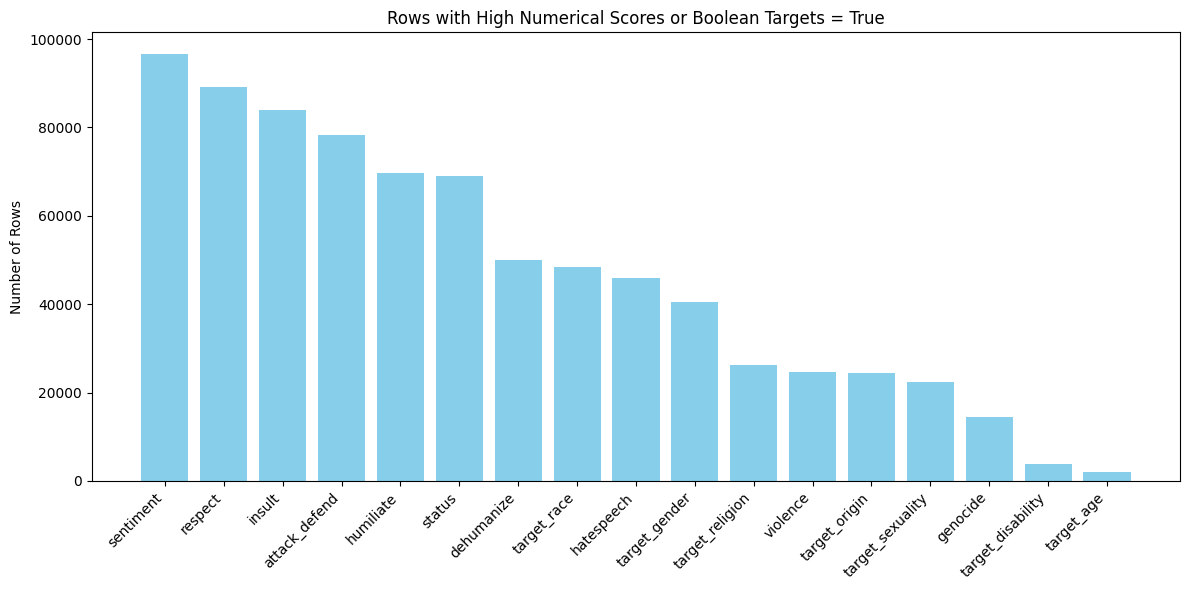

In [22]:

import matplotlib.pyplot as plt

# Load your DataFrame
# df_i = pd.read_parquet("path_to_your_file.parquet")

# Define your numerical and boolean columns
numerical_cols = [
    "sentiment", "respect", "insult", "humiliate", "status",
    "violence", "dehumanize", "genocide", "hatespeech", "attack_defend"
]
boolean_cols = [
    "target_race", "target_religion", "target_origin", "target_gender",
    "target_sexuality", "target_age", "target_disability"
]

# Calculate the number of rows exceeding half the max value for numerical columns
num_above_half_max = {
    col: (df_i[col] > (df_i[col].max() / 2)).sum() for col in numerical_cols
}

# Count the number of rows where boolean columns are True
binary_true_counts = df_i[boolean_cols].sum().to_dict()

# Combine the counts
combined_counts = {**num_above_half_max, **binary_true_counts}

# Sort the combined counts in descending order
sorted_counts = dict(sorted(combined_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Rows")
plt.title("Rows with High Numerical Scores or Boolean Targets = True")
plt.tight_layout()
plt.show()


In [3]:
print(df_i["target_race"].sum())

48352


In [5]:
print(df_i.iloc[20003]["text"])
print(df_i.iloc[20003]["sentiment"])
print(df_i.iloc[20003]["respect"])   #disrespect
print(df_i.iloc[20003]["insult"])
print(df_i.iloc[20003]["humiliate"])
print(df_i.iloc[20003]["status"])
print(df_i.iloc[20003]["violence"])                   # enlever ?
print(df_i.iloc[20003]["dehumanize"])
print(df_i.iloc[20003]["genocide"])                   # enlever ?
print(df_i.iloc[20003]["hatespeech"])
print(df_i.iloc[20003]["attack_defend"])
print(df_i.iloc[20003]["target_race"])
print(df_i.iloc[20003]["target_religion"])
print(df_i.iloc[20003]["target_origin"])
print(df_i.iloc[20003]["target_gender"])
print(df_i.iloc[20003]["target_sexuality"])
print(df_i.iloc[20003]["target_age"])                 # enlever ?
print(df_i.iloc[20003]["target_disability"])          # enlever ?

# add maybe "annotator_ideology"


This lil black fucking nigga
4.0
4.0
3.0
1.0
3.0
0.0
2.0
0.0
2.0
4.0
True
False
False
False
False
False
False


In [8]:
# take a subset to see if it works

#df = df_1.dropna(subset=['text'])
#df = df.head(20000)  # Only keep the first 2000 rows for fast testing

df=df_i   #for all rows of the dataset


In [9]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split

df = df.dropna(subset=['text'])    #remove rows that miss the column text

# Define columns
numerical_cols = ['sentiment', 'respect', 'insult', 'humiliate', 'status', 'violence',
                  'dehumanize', 'genocide', 'attack_defend', 'hatespeech']
binary_cols = ['target_race', 'target_religion', 'target_origin', 'target_gender',
               'target_sexuality', 'target_age', 'target_disability']

# Convert binary to 0/1
df[binary_cols] = df[binary_cols].astype(int)

# Split
train_texts, val_texts, train_y_num, val_y_num, train_y_bin, val_y_bin = train_test_split(
    df['text'], df[numerical_cols], df[binary_cols], test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class HateSpeechDataset(Dataset):
    def __init__(self, texts, targets_num, targets_bin, tokenizer, max_len=128):
        self.texts = list(texts)
        self.targets_num = torch.tensor(targets_num.values, dtype=torch.float)
        self.targets_bin = torch.tensor(targets_bin.values, dtype=torch.float)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'num_targets': self.targets_num[idx],
            'bin_targets': self.targets_bin[idx]
        }

train_ds = HateSpeechDataset(train_texts, train_y_num, train_y_bin, tokenizer)
val_ds = HateSpeechDataset(val_texts, val_y_num, val_y_bin, tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


In [10]:
class BERTMultiTaskModel(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", num_outputs=10, bin_outputs=7):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        
        # Regression head (for numerical values)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        
        # Classification head (for binary outputs)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, bin_outputs),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # [CLS] token
        return self.regressor(pooled), self.classifier(pooled)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTMultiTaskModel().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn_num = nn.MSELoss()
loss_fn_bin = nn.BCELoss()

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets_num = batch['num_targets'].to(device)
        targets_bin = batch['bin_targets'].to(device)

        optimizer.zero_grad()
        out_num, out_bin = model(input_ids, attention_mask)

        loss_num = loss_fn_num(out_num, targets_num)
        loss_bin = loss_fn_bin(out_bin, targets_bin)
        loss = loss_num + loss_bin
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets_num = batch['num_targets'].to(device)
            targets_bin = batch['bin_targets'].to(device)

            out_num, out_bin = model(input_ids, attention_mask)
            loss_num = loss_fn_num(out_num, targets_num)
            loss_bin = loss_fn_bin(out_bin, targets_bin)
            loss = loss_num + loss_bin
            total_loss += loss.item()
    
    return total_loss / len(loader)


In [ ]:
# lancé à 11h50 - 12H27 pour toutes les colonnes 1 epoch
import os

# Load checkpoint if it exists
checkpoint_path = "checkpoint.pt"
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed from epoch {start_epoch}")

# Continue training from last checkpoint
num_epochs = 1  # Add how many epochs you want to run (total)
for epoch in range(start_epoch, start_epoch + num_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f"Saved checkpoint at epoch {epoch+1}")


In [ ]:
# save it
torch.save(model.state_dict(), "bert_multitask_alldata_epoch1.pt")
print("Final model saved to 'bert_multitask_alldata_epoch1.pt'")


# Load a saved model

In [17]:
# load it
model = BERTMultiTaskModel().to(device)
model.load_state_dict(torch.load("bert_multitask_epoch1.pt"))
model.eval()


/tmp/ipykernel_86/3639065399.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("bert_multitask_epoch1.pt"))


BERTMultiTaskModel(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [18]:
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, r2_score
import torch

model.eval()
all_preds_num, all_preds_bin = [], []
all_true_num, all_true_bin = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets_num = batch['num_targets'].to(device)
        targets_bin = batch['bin_targets'].to(device)

        preds_num, preds_bin = model(input_ids, attention_mask)

        all_preds_num.append(preds_num.cpu())
        all_preds_bin.append(preds_bin.cpu())
        all_true_num.append(targets_num.cpu())
        all_true_bin.append(targets_bin.cpu())

y_pred_num = torch.cat(all_preds_num).numpy()
y_true_num = torch.cat(all_true_num).numpy()
y_pred_bin = (torch.cat(all_preds_bin) > 0.5).numpy()
y_true_bin = torch.cat(all_true_bin).numpy()

print(" Regression (Numerical labels):")
print("• R² Score:", r2_score(y_true_num, y_pred_num))
print("• MSE:", mean_squared_error(y_true_num, y_pred_num))

print("\n Classification (Binary labels):")
print("• Accuracy:", accuracy_score(y_true_bin, y_pred_bin))
print("• F1 Macro:", f1_score(y_true_bin, y_pred_bin, average='macro'))
print("• F1 Micro:", f1_score(y_true_bin, y_pred_bin, average='micro'))


 Regression (Numerical labels):
• R² Score: 0.5346028208732605
• MSE: 0.6892206072807312

 Classification (Binary labels):
• Accuracy: 0.6778179403953969
• F1 Macro: 0.676479910980433
• F1 Micro: 0.8029185651431882


# Continue training the loaded model and save it with a different name

This trains with all data. Only change nom_extra_epochs.  
It takes approx 40mins to train for 1 epoch.  
Evaluate the model with the different scores, and save the results in results.ipynb

In [20]:
import os

# Define model and optimizer again
model = BERTMultiTaskModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


# Resume from checkpoint if available
checkpoint_path = "checkpoint.pt"
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed from epoch {start_epoch}")

# Define how many more epochs you want to train
num_extra_epochs = 1

# Training loop
for epoch in range(start_epoch, start_epoch + num_extra_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Save checkpoint for future resuming
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f"Saved checkpoint at epoch {epoch+1}")

    # Optional: also save a snapshot of the model separately
    torch.save(model.state_dict(), f"bertO_multitask_epoch{epoch+1}.pt")


/tmp/ipykernel_86/3770923959.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


✅ Resumed from epoch 1
📚 Epoch 2: Train Loss = 0.8056, Val Loss = 0.8355
Saved checkpoint at epoch 2


# Predict classes with a certain sentence, to personally evaluate the performance

In [ ]:
def predict_on_text(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        out_num, out_bin = model(input_ids, attention_mask)
    
    out_num = out_num.cpu().numpy().flatten()
    out_bin = (out_bin.cpu().numpy().flatten() > 0.5).astype(bool)
    
    # Mapping outputs to their feature names
    num_features = ['sentiment', 'respect', 'insult', 'humiliate', 'status', 'violence',
                    'dehumanize', 'genocide', 'attack_defend', 'hatespeech']
    bin_features = ['target_race', 'target_religion', 'target_origin', 'target_gender',
                    'target_sexuality', 'target_age', 'target_disability']

    return dict(zip(num_features + bin_features, list(out_num) + list(out_bin)))


In [ ]:
example = "this retarded men looks stupid"
prediction = predict_on_text(example, model, tokenizer, device)
print(prediction)